# Homework 7

Rex Thompson  
DATA 558 - Spring 2017  
5/29/2017

## "Reading" Assignment

TODO: Read and play with scikit-learn’s function SVC using the example:

http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html#sphx-glr-auto-examples-svm-plot-iris-py

Visualize the results as you change the kernel and/or vary the kernel parameters.

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

## Exercise 1

### Bullet 1

Using a similar approach to previous homeworks I get the following result:

$$
\nabla F(\beta) = -\frac{2}{n}\sum_{i=1}^n y_ix_i\max\big(0, 1-y_ix_i^T\beta\big) + 2\lambda\beta
$$

Note that my $x_i$'s are transposed in the equation above compared to the functions defined below since the given objective function assumes $X$ to be a $ d \times n$ matrix, whereas my data import below results in an $n \times d$ matrix. Note that I also switched $x_i$ and $y_i$ just to the right of the sum term; while not required in the equation above, I wrote it this way since this is the order I needed to get the dimensions to work out when writing function in vector form below.

### Bullet 2

In [1]:
# initial setup
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import sklearn.preprocessing

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
# data import and standardization
# spam = pd.read_table('https://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/spam.data',
#                      sep=' ', header=None)
# test_indicator = pd.read_table('https://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/spam.traintest', sep=' ',
#                                header=None)
spam = pd.read_table('./Supplementals/spam.data',sep=' ', header=None)
test_indicator = pd.read_table('./Supplementals/spam.traintest.txt',sep=' ', header=None)
# confirmed there is no missing data in the spam dataset

# split out predictors and response
X = np.array(spam)[:,:-1]
y = np.array(spam)[:,-1]*2-1  # convert to +/-1

# define training and test sets based on labels provided
test_indicator = np.array(test_indicator).T[0]
X_train = X[test_indicator == 0]
X_test = X[test_indicator == 1]
y_train = y[test_indicator == 0]
y_test = y[test_indicator == 1]

# scale and center predictors
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test);

### Bullet 3

First I need to define the objective and gradient functions for use by `mylienarsvm`.

In [3]:
def calc_obj(beta, X, y, lam):
    inside = np.maximum(0, (1-y*X.dot(beta)))
    return (1/len(X))*np.dot(inside, inside) + lam*np.dot(beta, beta)

In [4]:
def computegrad(beta, X, y, lam):
    return -(2/len(X))*X.T.dot(y*np.maximum(0, (1-y*X.dot(beta)))) + 2*lam*beta

I also redefine a function to perform the backtracking rule; for this I pull directly from my solutions to Homework 3.

In [5]:
def backtracking(beta, X, y, lam, stepSize_init, alpha=0.5, gamma=0.8):
    grad = computegrad(beta, X, y, lam)
    lhs = 1 # for entering while loop
    rhs = 0 # for entering while loop
    t = 0
    stepSize = copy.deepcopy(stepSize_init)
    while lhs > rhs:
        if t == 1:
            stepSize = gamma*stepSize
        else:
            t = 1
        lhs = calc_obj(beta - stepSize*grad, X, y, lam)
        rhs = calc_obj(beta, X, y, lam) - alpha*stepSize*grad.dot(grad)
    return stepSize

Now I can define my `mylinearsvm` function, which is basically identical my `fastgradalgo` from Homework 3, but with a different name. And of course, the functions upon which it depends are now different (i.e. `computegrad` and `calc_obj`).

In [6]:
def mylinearsvm(beta_init, X, y, lam, stepSize_init, max_iter):
    beta = copy.deepcopy(beta_init)
    theta = copy.deepcopy(beta_init)
    stepCoords = [beta]
    it = 0
    while it < max_iter:
        stepSize = backtracking(beta, X, y, lam, stepSize_init)
        betaNew = theta - stepSize*computegrad(theta, X, y, lam)
        theta = betaNew + (it/(it+3))*(betaNew - beta)
        beta = copy.deepcopy(betaNew)
        stepCoords.append(np.array(beta))
        it += 1
    return np.vstack(stepCoords)

### Bullet 4

I train my linear support vector machine using $\lambda = 1$; the plot below shows the coefficients through the first 10 steps. Note that I select an initial step size per the formula on Slide 28 of the Week 3 lecture notes.

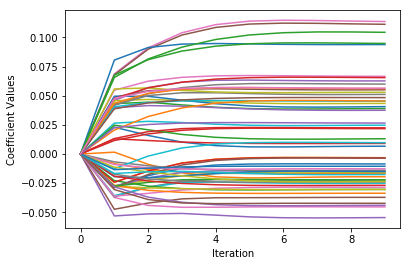

In [7]:
lam = 1
n_train, p_train = X_train.shape
stepSize_init = 1 / (scipy.linalg.eigh((1/n_train)*X_train.T.dot(X_train),
                                       eigvals=(p_train-1, p_train-1), eigvals_only=True)[0] + lam)
betas = mylinearsvm(np.zeros(p_train), X_train, y_train, lam, stepSize_init, 1000)
plt.plot(betas[0:10])
plt.xlabel("Iteration")
plt.ylabel("Coefficient Values");

I check my resulting coefficients (after my final step) against those derived using scikit-learn's LinearSVC funciton. I was unable to figure out the objective function they use but through trial and error I was able to get results that matched almost exactly; I had to set their C-value equal to 1/2n$\lambda$ (i.e. the same adjustment I had to make to get my logistic classifier function to match).

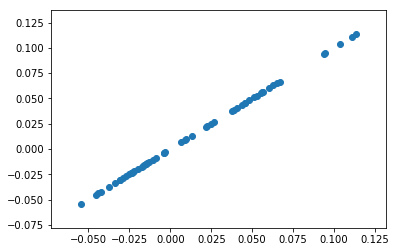

In [8]:
from sklearn.svm import LinearSVC
sh = LinearSVC(C = 1/(2*n_train*lam), fit_intercept=False)
sh.fit(X_train, y_train)
plt.scatter(sh.coef_, betas[-1]); plt.show();

I now define a function to compute the misclassification error. This is basically the same function I wrote for Homework 3, except I now output the actual predictions (for troubleshooting purposes), and I no longer return the error at each step (the function now only accepts a single beta vector, rather than betas at each step).

In [9]:
def calc_error(beta, X, y):
    prob = 1/(1+np.exp(-X.dot(beta))) > 0.5 # expit function
    prob = prob*2-1 # adjust to same scale as training/test data (+/-1)
    error_rate = 1-np.sum(prob == y)/len(X) # compare to training/test data
    return error_rate, prob

The test misclassification error when $\lambda$ = 1 is as follows:

In [10]:
error = calc_error(betas[-1], X_test, y_test)
print("Misclassification error: " + str(round(100*error[0], 1)) + "%")

Misclassification error: 9.5%


### Bullet 5

I implement k-folds cross-validation to find the optimal $\lambda$ value. I use 6 folds.

In [11]:
folds = 6
kf = KFold(folds, shuffle=True, random_state=0)
lambdas = np.array([10**k for k in range(-10, 1)])
all_errors = np.empty((0, folds))
for lam in lambdas:
    fold_errors = np.array([])
    for train_index, test_index in kf.split(X_train, y_train):
        X_train_CV, X_test_CV = X_train[train_index], X_train[test_index]
        y_train_CV, y_test_CV = y_train[train_index], y_train[test_index]
        n_train_CV, p_train_CV = X_train_CV.shape
        stepSize_init = 1 / (scipy.linalg.eigh((1/n_train_CV)*X_train_CV.T.dot(X_train_CV),
                                       eigvals=(p_train_CV-1, p_train_CV-1), eigvals_only=True)[0] + lam)
        betas = mylinearsvm(np.zeros(p_train_CV), X_train_CV, y_train_CV, lam, stepSize_init, 1000)
        error = calc_error(betas[-1], X_test_CV, y_test_CV)
        fold_errors = np.append(fold_errors, error[0])
    all_errors = np.vstack((all_errors, fold_errors))

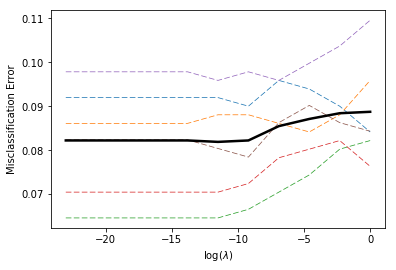

In [12]:
mean_error = np.mean(all_errors, axis=1);
plt.plot(np.log(lambdas), all_errors, "--", linewidth=.75)
plt.plot(np.log(lambdas), mean_error, "black", linewidth=2.5)
plt.xlabel('log' + r'($\lambda)$')
plt.ylabel('Misclassification Error');

The plot above shows the misclassification error as a function of log($\lambda$) for all six folds. The mean of the errors at each $\lambda$ is shown in black. Below I display the $\lambda$ values, the mean misclassification error at each $\lambda$, and the best $\lambda$.

In [13]:
lambdas
mean_error
max_min_index = np.max(np.where(mean_error == mean_error.min()))
lam = lambdas[np.max(np.where(mean_error == mean_error.min()))]
print("best lambda =", lam)

array([  1.00000000e-10,   1.00000000e-09,   1.00000000e-08,
         1.00000000e-07,   1.00000000e-06,   1.00000000e-05,
         1.00000000e-04,   1.00000000e-03,   1.00000000e-02,
         1.00000000e-01,   1.00000000e+00])

array([ 0.08221864,  0.08221864,  0.08221864,  0.08221864,  0.08221864,
        0.08189184,  0.08221736,  0.0854815 ,  0.08711357,  0.08841692,
        0.08874244])

best lambda =  1e-05


I now calculate the misclassification error on the test set using the optimal $\lambda$ determined above (i.e. 1e-05).

In [16]:
stepSize_init = 1 / (scipy.linalg.eigh((1/n_train)*X_train.T.dot(X_train),
                                       eigvals=(p_train-1, p_train-1), eigvals_only=True)[0] + lam)
betas = mylinearsvm(np.zeros(p_train), X_train, y_train, lam, stepSize_init, 1000)
error = calc_error(betas[-1], X_test, y_test)
print("Misclassification error: " + str(round(100*error[0], 1)) + "%")

Misclassification error: 7.9%


As expected, this is an improvement over the results when using an arbitrary $\lambda$ value of 1.

## Exercise 2: Kaggle